<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/NLP/1_Introduccion/Introduccion.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

# Procesamiento de Lenguaje Natural (NLP)



In [ ]:
#@title Preparamos Dataset de Medios de Latinoamérica
%%capture
!pip install datasets
import pandas as pd
from datasets import load_dataset

data = pd.DataFrame()
configs = ['ar', 'bo', 'br', 'cl', 'co', 'cr', 'gt', 'hn', 'mx', 'ni', 'pa', 'pe', 'pr', 'py', 'sv', 'uy', 've'] # 'com', 'es'
for c in configs:
  data_ = load_dataset("LeoCordoba/CC-NEWS-ES", c)
  data = data.append(data_['train'].to_pandas())

data = data.drop('id', axis=1).reset_index(drop=True)
# Hacemos "downsampling" tomando maximo n_min para 
# los grupos que tienen > n_min, y todos para los que tienen menos
n_min = 1000
df_grouped = data.groupby("country")
df_grouped.groups.values()
frames_of_groups = [x.sample(n_min) if x.shape[0] > n_min else x for y, x in df_grouped] 
data = pd.concat(frames_of_groups)

In [103]:
# Ejecutar la celda de arriba para preparar los datos
print(data.shape[0])
data.sample(2)

15561


,country,text
1488725,ni,"La gente se siente insegura, pero no solo en S..."
591577,cl,En el primer Centro de Entrenamiento de Riesgo...


### Definición


El Procesamiento de Lenguaje Natural (NLP por sus siglas en inglés, **Natural Language Processing**) es un campo compartido entre Lingüística y la Computación, incluyendo al Aprendizaje Automático (ML). 

Busca, como su nombre lo dice, aplicar sobre el lenguaje natural con herramientas algorítmicas para extraer información, categorizar, traducir, entre otras tareas con el objetivo de fondo el objetivo es lograr que las computadoras "comprendan" el lenguaje, 

Puede, o no, usar aprendizaje automático: computar las N palabras más frecuentes en un texto por ejemplo, sería un proceso básico de NLP, que no utiliza ML. 

### Tareas Importantes

- Traducción de habla a escritura: la conversión de los fonemas en un audio a su representación escrita (grafema)

- Clasificación:
  - Clasificar oraciones enteras: detectar si un E-mail es spam o no, determinar si una oración es gramaticalmente correcta, análisis de sentimiento, moderación de ofensas, etc.

  - Clasificar cada palabra en una oración: identificar los componentes gramaticales (sustantivo, adjetivo, verbo) o las entidades mencionadas (persona, lugar, organización)

  - Modelado de Tópicos, usado mucho en *social listening*. 

- Generación de texto:
  - Generar texto: generar copy para publicidades, escribir noticias, conversar, arte, etc.

  - Resumen abstractivo / resumen extractivo: Extraer de una respuesta de un texto: responder una pregunta dada en base al contexto

  - Traducción: Traducir un texto de un idioma a otro o de un estilo a otro (style transfer)

- Agentes de Diálogo: asistentes virtuales, atención al cliente, chatbots orientados a tareas específicas.

Los dominios de aplicación de estas tecnologías son innumerables, yendo desde aplicaciones triviales hasta aplicaciones como [*Speech2face*](https://speech2face.github.io/)

<center><img src="https://speech2face.github.io/images/teaser_side.jpg" alt="Paris" align="center" width="300px" style="text-align:center;"></center>

# Métodos tradicionales del NLP

En las próximas clases se verá el *estado del arte* basado en Aprendizaje Profundo. Sin embargo, existe un gran repertorio de técnicas más allá de eso. Conocerlas nos servirá para entender esas herramientas, y en muchas ocasiones estas técnicas tradicionales son un buen complemento para preparación y limpieza de datos, o incluso pueden ser la solución deseada si una red neuronal pesada no es conveniente.

Las próximas clases se centrarán en redes usando PyTorch. Hoy conoceremos las siguientes técnias y liberías:

Herramientas de NLP que veremos:
 - Expresiones Regulares con `re`
 - Búsqueda difusa de string con `thefuzz`

Procesos de normalización, preprocesamiento:
 - *Stemming* con `nltk`
 - *Lemmatización* con `spacy`
 - *Stop Words*

Modos de representación:
 - Bolsa de Palabras y 
 - TF-IDF `con sklearn`


### Tokenización

Quizás una de las operaciones más básicas que podemos hacer es contar palabras. Imaginemos un caso extremadamente sencillo relacionado al aprendizaje automático. Pensemos en un **clasificador de positividad / negatividad**.

Podríamos usar una regla como:

```si "bueno" está en el texto, clasificamos como positivo```.

Claramente un enfoque tan sencillo va a ser propenso a muchos errores. Iremos viendo cómo aplicarlo y mejorarlo. 

La operación de separar los textos en unidades básicas (o ***tokens***) la llamamos ***tokenización***. 

In [105]:
doc2 = 'Usualmente, existe una relación costo-beneficio entre las distintas técnicas.'
doc2.split(' ')

['Usualmente,',
 'existe',
 'una',
 'relación',
 'costo-beneficio',
 'entre',
 'las',
 'distintas',
 'técnicas.']

Vemos que en castellano, el lenguaje natural (escrito) puede tener distintas fuentes de variaciones:
 - Mayúsculas
 - Tildes
 - Signos ortográficos
 - Errores de tipeo
 - Variaciones propias del lenguaje como la conjugación
 - Artefactos de la escritura informal como "holaaa"

¿Cómo abordarán esto nuestros algorítmos? 

Una solución es la **normalización**: con acepción similar aunque distinta a la que usamos en estadística, va a significar transformar a los strings a representaciones iguales. 

Podemos:
- Sacar espacios
- Pasar a minúsculas
- Quitar tildes

In [106]:
%%capture
!pip install unidecode

In [109]:
import unidecode
[unidecode.unidecode(w.lower().strip()) for w in doc2.split(' ')]

['usualmente,',
 'existe',
 'una',
 'relacion',
 'costo-beneficio',
 'entre',
 'las',
 'distintas',
 'tecnicas.']

Otras normalizaciones más sofisticadas serían:
- Pasar de plural a singular
- Convertir el género de la palabra
- Conjugar los verbos en infinitivo

¡Es de esperarse que esto requiera métodos más complejos!

Vemos que con la tokenización anterior, todavía tenemos palabras con signos de puntuación pegados. Armar nuestro vocabulario es un paso clave para nuestros modelos de *Machine Learning*. 

## Expresiones regulares


También conocido popularmente como **RegEx**. Es un mini lenguaje de programación diseñado para realizar búsquedas en strings. Son extremadamente útiles para:
- Extraer datos de distintos tipos de archivos, texto o con otro tipo de codificación.
- Web scraping: como veremos en las próximas clases, las regex son un buen método para encontrar la información que se necesita en un sitio web.
- Limpieza de datos: herramienta fundamental en el repertorio del científico de datos para limpiar datos quitando caracteres "ruidosos", o armando nuevos "features" según la presencia o no de cierto texto.


Para profundizar en esta importante herramienta, ver la [clase de Expresiones Regulares](https://github.com/institutohumai/cursos-python/tree/master/Automatizacion) del curso de Automatización.


Recursos útiles para regex:

- [Sitio para armar RegEx online](https://regexr.com/)
- [Alternativa](https://regex101.com/)
- [CheatSheet](https://www.dataquest.io/wp-content/uploads/2019/03/python-regular-expressions-cheat-sheet.pdf)


Python utiliza la libreria llamada **re** para todo lo relacionado a regular expressions

In [110]:
# Tokenización simple con RegEx
import re
re.findall('\w+', doc2)

['Usualmente',
 'existe',
 'una',
 'relación',
 'costo',
 'beneficio',
 'entre',
 'las',
 'distintas',
 'técnicas']

## NLTK

La librería [Natural Languaje Toolkit](https://www.nltk.org/) es un *de facto* para NLP en Python para diversos idiomas. No solo contiene algoritmos para operaciones de NLP si no también corpus de textos y vocabulario organizado como [WordNet](https://wordnet.princeton.edu).

In [112]:
# Tokenización con NLTK
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [113]:
tokens = nltk.word_tokenize(doc2)
print(tokens)

['Usualmente', ',', 'existe', 'una', 'relación', 'costo-beneficio', 'entre', 'las', 'distintas', 'técnicas', '.']


## Distancia de edición 

Para afrontar el "ruido" en nuestros textos, tenemos una importante herramienta: la distancia de edición.

También llamada Distancia de Levenshtein, nos dice la cantidad mínima de operaciones requerida para llevar de un string al otro. Expresandola de una manera sencilla (y en su versión sin normalizar entre 0 y 1) podemos explicarla así:

$$\mathit{L} = S+D+I$$

Donde $S$ = sustitución, $D$ = Eliminación, $I$ = inserción (de un caracter).


Como en muchos idiomas la raíz importa más que el resto de la palabra, a veces se usa la métrica Jaro Winkler que pondera más los caracteres iniciales.

In [114]:
%%capture
!pip install pyjarowinkler
from nltk.metrics import edit_distance
from pyjarowinkler import distance as jwdist

In [115]:
# Definimos una lista de tuplas de palabras
palabras = [("pero", "perro"),("pero", "pierdo"), ("nueve", "mueve"),  ("totalmente","diferentes"), ("pero", "basta")]

# Calculamos las metricas de distancia pasando cada tupla como argumentos a levdist() y get_jaro_distance()
for x,y in palabras:
    print(f"'{x}' vs '{y}':")
    print("Distancia Levenshtein ->", edit_distance(x,y))
    print("Similitud Jaro Winkler ->",jwdist.get_jaro_distance(x,y))
    print("-"*40)

'pero' vs 'perro':
Distancia Levenshtein -> 1
Similitud Jaro Winkler -> 0.95
----------------------------------------
'pero' vs 'pierdo':
Distancia Levenshtein -> 2
Similitud Jaro Winkler -> 0.9
----------------------------------------
'nueve' vs 'mueve':
Distancia Levenshtein -> 1
Similitud Jaro Winkler -> 0.87
----------------------------------------
'totalmente' vs 'diferentes':
Distancia Levenshtein -> 7
Similitud Jaro Winkler -> 0.52
----------------------------------------
'pero' vs 'basta':
Distancia Levenshtein -> 5
Similitud Jaro Winkler -> 0.0
----------------------------------------


## Búsqueda difusa de strings (fuzzy string matching)

Técnica muy útil para tener en el repertorio, nos permite encontrar coincidencias que no son exactas. En el caso más sencillo, la búsqueda difusa nos devolverá un puntaje de similitud entre los strings relacionada a las diferencias entre los caracteres. Existen variaciones que consideran cuántas unidades (palabras, tokens) coinciden, que ordenan la oración antes, o que borran repetidos. 

In [12]:
%%capture
!pip install thefuzz[speedup]
from thefuzz import process, fuzz

In [116]:
def get_match(string, lista_strings):
    """Para buscar coincidencias entre nombre con los nombres"""
    mejor_match, puntaje = process.extractBests(string.strip(), lista_strings, scorer=fuzz.token_set_ratio)[0]
    return mejor_match, puntaje

In [118]:
# Completar
busqueda = 'Pebro'
candidatos = 'María, Fabio, Paula, Natu, Pedro, Miguel'.split(', ')

get_match(busqueda, candidatos)

('Pedro', 80)

# Hacia el ML: Representación

Lo anterior nos puede servir para un sinfín de algorítmos útiles de NLP. En el caso del *Machine Learning* (ML) para usar nuestro modelo (o para cualquier operación vectorial), tendremos que llevar a nuestros datos a una representación matricial. Las maneras de lograr esto se pueden denominar "**vectorizar**".


En un caso de querer **clasificar artículos** en algunas categorías predeterminadas, una tabla simple de ejemplo se podría ver así: 

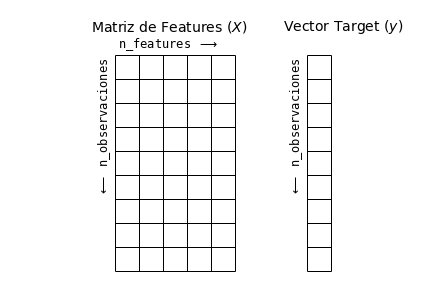

In [15]:
#@title Matriz de Features
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.axis('equal')

# Draw features matrix
ax.vlines(range(6), ymin=0, ymax=9, lw=1)
ax.hlines(range(10), xmin=0, xmax=5, lw=1)
font_prop = dict(size=12, family='monospace')
ax.text(-1, -1, "Matriz de Features ($X$)", size=14)
ax.text(0.1, -0.3, r'n_features $\longrightarrow$', **font_prop)
ax.text(-0.1, 0.1, r'$\longleftarrow$ n_observaciones', rotation=90,
        va='top', ha='right', **font_prop)

# Draw labels vector
ax.vlines(range(8, 10), ymin=0, ymax=9, lw=1)
ax.hlines(range(10), xmin=8, xmax=9, lw=1)
ax.text(7, -1, "Vector Target ($y$)", size=14)
ax.text(7.9, 0.1, r'$\longleftarrow$ n_observaciones', rotation=90,
        va='top', ha='right', **font_prop)

ax.set_ylim(10, -2);

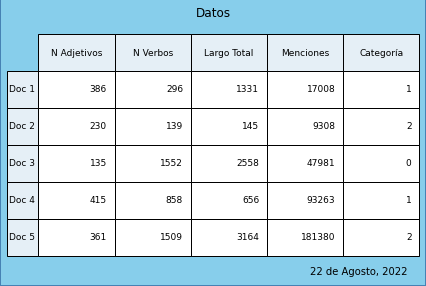

In [17]:
#@title Tabla Ejemplo
import numpy as np
import matplotlib.pyplot as plt
title_text = 'Datos'
footer_text = '22 de Agosto, 2022'
fig_background_color = 'skyblue'
fig_border = 'steelblue'
data_ =  [
            [         'N Adjetivos', 'N Verbos', 'Largo Total', 'Menciones', 'Categoría'],
            [ 'Doc 1',  386, 296,   1331,  17008,  1],
            ['Doc 2',  230, 139,   145,   9308, 2],
            ['Doc 3',  135,  1552,  2558,  47981, 0],
            ['Doc 4',  415,  858,  656,  93263,  1],
            ['Doc 5', 361, 1509,  3164,  181380,  2],
        ]
column_headers = data_.pop(0)
row_headers = [x.pop(0) for x in data_]

cell_text = []
for row in data_:
    cell_text.append([f'{x}' for x in row])
rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))
plt.figure(linewidth=2,
           edgecolor=fig_border,
           facecolor=fig_background_color,
           tight_layout={'pad':1},
           #figsize=(5,3)
          )
the_table = plt.table(cellText=cell_text,
                      rowLabels=row_headers,
                      rowColours=rcolors,
                      rowLoc='right',
                      colColours=ccolors,
                      colLabels=column_headers,
                      loc='center')
the_table.scale(1, 2.5)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.suptitle(title_text)
plt.figtext(0.95, 0.05, footer_text, horizontalalignment='right', size=10, weight='light')
plt.draw()

Para operar sobre la información de texto directamente, el enfoque tradicional más sencillo es la **bolsa de palabras**. Vamos a crearla con sci-kit learn:

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [120]:
# Instanciamos el CV
vec = CountVectorizer()

doc1 = 'la matriz de frecuencias otorga información del contenido de un documento'
doc2 = 'las palabras que aparecen en un documento reflejan sus tópicos'

# Definimos una lista con todos los strings
textos = [doc1, doc2]

# Ajustamos el CV y transformamos los datos
X = vec.fit_transform(textos) 

Podemos volcar este resultado en un `DataFrame`. Para obtener el encabezado de las columnas, vamos a utilizar el método `get_feature_names_out()`, propio del vectorizador.

In [121]:
import pandas as pd
pd.DataFrame(data = X.todense(), columns = vec.get_feature_names_out()).style.background_gradient()

,aparecen,contenido,de,del,documento,en,frecuencias,información,la,las,matriz,otorga,palabras,que,reflejan,sus,tópicos,un
0,0,1,2,1,1,0,1,1,1,0,1,1,0,0,0,0,0,1
1,1,0,0,0,1,1,0,0,0,1,0,0,1,1,1,1,1,1


Una vez que tenemos nuestros datos ordenados, podemos ajustar nuestro modelo de aprendizaje automático aproximadamente así:

```python
from sklearn.familia_de_modelos import Modelo
mi_modelo = Modelo(hiperparámetros)
mi_modelo.fit(X, y)

predicción = mi_modelo.predict(nuevo_X)
```

Para ajustar nuestros modelos de machine learning, vamos a tener nuestra matriz de features **X** y un vector **y** (en el caso de ML supervisado), donde **X** tiene la forma ``(n_observaciones, n_variables)`` e **y** ``(n_observaciones)``

# TF-IDF

**Term frequency-inverse document frequency (TF–IDF)** es una técnica alternativa que computa la frecuencia relativa de cada palabra por documento, ponderada por la inversa de su frecuencia relativa a lo largo del *corpus* (colección de documentos). Este método funciona mejor con ciertos algoritmos de clasificación, y es ámpliamente utilizada

Vamos a calcular las matrices de ocurrencias de términos usando sklearn.

Ámbas clases primero construyen el vocabulario total, y luego:  
- **CountVectorizer** nos devuelve la frecuencia absoluta de cada término por cada documento.
- [**TF-IDF**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf): calcula la frecuencia de cada término por documento, y normaliza por el total de documentos donde el término aparece.

$${tf} (t,d)={\frac {f_{t,d}}{\sum _{t'\in d}{f_{t',d}}}}$$

$$
idf( t, D ) = log \frac{ \text{| } D \text{ |} }{ 1 + \text{| } \{ d \in D : t \in d \} \text{ |} }
$$ 


$$ tfidf( t, d, D ) = tf( t, d ) \times idf( t, D ) 
$$


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(textos)
pd.DataFrame(data = X.todense(), 
             columns = vec.get_feature_names_out()).style.background_gradient()

,aparecen,contenido,de,del,documento,en,frecuencias,información,la,las,matriz,otorga,palabras,que,reflejan,sus,tópicos,un
0,0.000000,0.288525,0.577050,0.288525,0.205288,0.000000,0.288525,0.288525,0.288525,0.000000,0.288525,0.288525,0.000000,0.000000,0.000000,0.000000,0.000000,0.205288
1,0.333102,0.000000,0.000000,0.000000,0.237005,0.333102,0.000000,0.000000,0.000000,0.333102,0.000000,0.000000,0.333102,0.333102,0.333102,0.333102,0.333102,0.237005


## Similitud coseno

Recordando rápidamente la métrica de similitud coseno, podemos utilizarla en conjunto con TF-IDF para calcular similitud entre textos!

$$sim(\pmb x, \pmb y) = \frac {\pmb x \cdot \pmb y}{||\pmb x|| \cdot ||\pmb y||}$$

Con los elementos vistos ya podemos construir el algoritmo de Análisis Semántico Latente, que fue de vanguardia y muy exitoso por muchos años. 

Para un ejemplo de TF-IDF con similitud coseno, en el contexto de sistemas de recomendación, véase [la última clase de Machine Learning](https://github.com/institutohumai/cursos-python).

## N-gramas

Muchas veces la unidad lingüística no es una palabra si no que es una palabra compuesta, ya sea en un nombre (ej. "La Rioja") como en palabras compuestas ("italo-americano"). Tomando palabras sueltas, esos significados se pierden.
Para contemplar esto, se pueden tomar combinaciones de N palabras: **n-gramas**.

In [122]:
data['text'] = data['text'].apply(lambda x: x[:1000])

In [124]:
# Definimos una lista con los documentos
textos = data['text']

# Instanciamos un CountVectorizer con una tupla indicando el rango de los n-gramas a considerar
vectorizer = CountVectorizer(ngram_range=(2,3), min_df=20)

# Usamos .fit_transform() para ajustar el CV y transformar los datos
X = vectorizer.fit_transform(textos)
print(X.toarray())

# Usando .get_feature_names_out() podemos acceder al indice de palabras
print(vectorizer.get_feature_names_out())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['00 de' '00 de la' '00 en' ... 'únicamente una' 'únicamente una nueva'
 'único que']


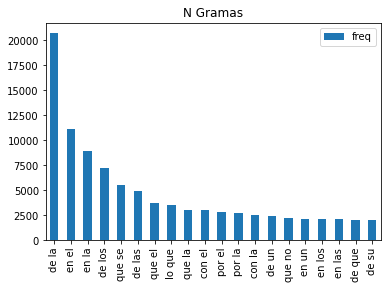

In [125]:
pd.DataFrame(X.sum(axis=0).T,
            index=vectorizer.get_feature_names_out(),
            columns=['freq']).sort_values(by='freq',
                                          ascending=False)[:20].plot(kind='bar',title='N Gramas');

## Stop Words



In [ ]:
!pip install stop_words
import stop_words
# Usamos stop words del español
stop_words = stop_words.get_stop_words('es')

In [127]:
# Instanciamos un CountVectorizer con una tupla indicando el rango de los n-gramas a considerar
vectorizer = CountVectorizer(ngram_range=(2,3), min_df=10, stop_words=stop_words)

# Usamos .fit_transform() para ajustar el CV y transformar los datos
X = vectorizer.fit_transform(textos)

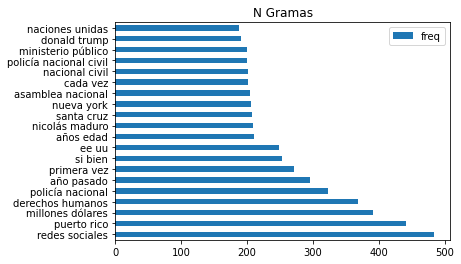

In [28]:
import matplotlib.pyplot as plt
pd.DataFrame(X.sum(axis=0).T,
            index=vectorizer.get_feature_names_out(),
            columns=['freq']).sort_values(by='freq',
                                          ascending=False)[:20].plot(kind='barh',title='N Gramas');

## Stemming

In [29]:
# Instanciamos SnowballStemmer() de NLTK en español
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [30]:
# Aplicamos el stemming para cada palabra pasando el string al metodo .stem()
ejemplo = 'mirar miraré codear hacer hachas'
[stemmer.stem(i) for i in nltk.word_tokenize(ejemplo)]

['mir', 'mir', 'cod', 'hac', 'hach']

¿Qué ventajas y desventajas piensan que conlleva el uso de *stemming*?

# SpaCy

Mientras NLTK se centra en técnicas más bien tradicionales, [spaCy](https://spacy.io/) ofrece una API muy cómoda que integra modelos de aprendizaje automático que resuelven tareas típicas de lingüística computacional.


In [31]:
%%capture
!python -m spacy download es_core_news_md
import numpy as np
import spacy
from spacy import displacy

In [32]:
# Inicializamos Spacy con modelos en español
nlp = spacy.load('es_core_news_md')

In [33]:
ejemplo = 'El Doctor afirmó que actuando de maneras probabilísticas el cerebro aprende conceptos discretos. ¡Qué fenómeno misterioso!'

In [128]:
# Instanciamos un Doc de spacy con nuestro texto
doc = nlp(ejemplo)
type(doc)

spacy.tokens.doc.Doc

In [133]:
for word in doc: 
    print(word.text)

El
Doctor
afirmó
que
actuando
de
maneras
probabilísticas
el
cerebro
aprende
conceptos
discretos
.
¡
Qué
fenómeno
misterioso
!


In [36]:
doc

El Doctor afirmó que actuando de maneras probabilísticas el cerebro aprende conceptos discretos. ¡Qué fenómeno misterioso!

## Lemmatización

El *stemming* vemos que es un enfoque bastante bruto para normalizar, desechando parte de la información de la palabra. Podemos tener un problema de polisemia, con una raíz refiriendo a palabras muy distintas. La solución a esto es la **lematización**, que busca llevar a una palabra a su forma canónica o esencial. 

In [135]:
for word in doc:
    print(word.lemma_)

el
Doctor
afirmar
que
actuar
de
manera
probabilística
el
cerebro
aprender
concepto
discreto
.
¡
qué
fenómeno
misterioso
!


## Limitaciones de la Bolsa de Palabras

Utilizando las técnicas que vimos (normalización, n-gramas, stop words) podemos mejorar significativamente el rendimiento de algoritmos de Aprendizaje Automático que se basan en bolsa de palabras. 

Sin embargo, si entrenamos un clasificador usando esta matriz, lo que hará es encontrar relaciones estadísticas entre la ocurrencia de cierto token con su categoría (en el caso supervisado). ¿Qué problemas se te puede que puede tener?

- Contexto
- Orden
- Dimensionalidad (variaciones en las palabras, n gramas)


En las próximas clases veremos cómo las redes neuronales abordan estos obstáculos.

# Tareas de NLP 

SpaCy integra en su API de una manera elegante atributos y métodos generados por modelos de Aprendizaje Automático.

## Segmentación de oraciones

In [38]:
list(doc.sents)

[El Doctor afirmó que actuando de maneras probabilísticas el cerebro aprende conceptos discretos.,
 ¡Qué fenómeno misterioso!]

## Part-Of-Speech Tags

Podemos estimar la función gramatical de cada palabra, accediendo directamente al atributo `.pos_` de cada token:


In [136]:
for word in doc:
    print(word.text, word.pos_)

El DET
Doctor PROPN
afirmó VERB
que SCONJ
actuando VERB
de ADP
maneras NOUN
probabilísticas ADJ
el DET
cerebro NOUN
aprende VERB
conceptos NOUN
discretos ADJ
. PUNCT
¡ PUNCT
Qué DET
fenómeno NOUN
misterioso ADJ
! PUNCT


## Dependency parsing

¡También contamos con información sobre la co-referencia o dependencia sintáctica entre términos!

In [40]:
displacy.render(doc, style='dep', jupyter=True)

## Reconocimiento de Entidades

Podemos encontrar las personas (más general, "entes") que se mencionan en los textos:

In [41]:
doc.ents

(El Doctor,)

In [42]:
displacy.render(doc, style='ent', jupyter=True);

## Vectores de Palabras

Podemos acceder a los vectores con `.vector`. ¡Veremos en detalle este tema en las próximas clases!

In [43]:
def cosine_similarity(x, y):
    return x @ y / (np.linalg.norm(x) * np.linalg.norm(y))

In [63]:
doc

El Doctor afirmó que actuando de maneras probabilísticas el cerebro aprende conceptos discretos. ¡Qué fenómeno misterioso!

In [86]:
doc2 = nlp("La curiosidad por nuevas ideas es lo que impulsa a derivar ecuaciones y descubrir simetrías.")
doc3 = nlp("Una pizza de napolitana con ajo, una de muzzarella con jamón, media de chocolate y una cerveza roja.")

In [87]:
doc.similarity(doc2)

0.4817427186959799

In [88]:
doc.similarity(doc3)

0.3420021954777671

# Referencias:

- [Libro Jurafsky](https://web.stanford.edu/~jurafsky/slp3/)
- [Curso de HuggingFace](https://huggingface.co/course/chapter1/2?fw=pt)


![](https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fblogs-images.forbes.com%2Fgilpress%2Ffiles%2F2016%2F03%2FTime-1200x511.jpg)



# Caso: Clasificación de textos como Positivo o Negativo o _Sentiment Analysis_

Vamos a ver un ejemplo sencillo de clasificación de texto, haciendo un sentiment análisis de frases o positivas o negativas.

In [138]:
# Importamos 

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [140]:
df = pd.read_csv('https://datasets-humai.s3.amazonaws.com/datasets/sentiment.csv')
df.sample(10)

,Sentiment,Phrase
976,NEGATIVE,Es poco accesible al momento de atender nuestr...
1656,POSITIVE,buen material hace dianmica la clase
908,NEGATIVE,"Las clases son agotadoras, son demasiadas cosa..."
400,POSITIVE,Profesor accesible y inspira confianza para co...
264,NEGATIVE,No logra transmitir su conocimiento de una man...
203,POSITIVE,Excelente maestro. Muy interactivas sus clases...
1330,POSITIVE,son buenas sus asesorias como apoyo para los a...
770,POSITIVE,CONSIDERO QUE LA MAESTRA REALIZA MUY BIEN SU T...
1641,POSITIVE,Buen material de trabajo logra la atencion del...
228,POSITIVE,buen profesor ya que relaciona la teória con l...


In [141]:
df['Sentiment'].value_counts()

POSITIVE    941
NEGATIVE    743
Name: Sentiment, dtype: int64

In [142]:
# separamos train y test
train, test = train_test_split(df, test_size=0.33)

In [145]:
# Separamos en X e y
train_y = train.iloc[:,0]
train_X = train.iloc[:,1]
test_y = test.iloc[:,0]
test_X = test.iloc[:,1]

# Vectorizamos los textos por TF-IDF
vec = TfidfVectorizer(min_df=3)
model = MultinomialNB()
clf = make_pipeline(vec,model)

clf = clf.fit(train_X, train_y)

In [144]:
test_X

128     Sus clases son interactivas y aprendo mucho co...
1062                 clases más didácticas para cada tema
64      En ocaciones se expresa mal hacia los alumnos ...
1682    debería mejorar su manera de dar clases, tomar...
1066          deberia de dar sus clases con menos teoría 
                              ...                        
1598                   Mucha información genera confusión
954            No es congruente lo que dice y lo que hace
1110                El profesor no tiene dominio del tema
75      considero que debe ejercer mayor presencia en ...
811             QUE EXPLIQUE ALGUNAS COSAS MAS A DETALLE.
Name: Phrase, Length: 556, dtype: object

In [146]:
predictions = clf.predict(test_X)

In [147]:
sum(predictions == test_y) / len(test_y)

0.85431654676259

In [148]:
accuracy_score(test_y, predictions)

0.85431654676259

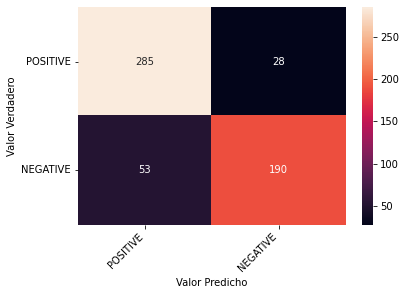

In [155]:
df_cm = confusion_matrix(test_y,predictions,labels=test_y.unique())
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(test_y.unique(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(test_y.unique(), rotation=45, ha='right')
plt.ylabel('Valor Verdadero')
plt.xlabel('Valor Predicho');

In [159]:
to_predict = "Fue terrible la clase, el profesor se tom\xF3 una siesta y nos hizo usar machine learning para ver cu\xE1nto tiempo dorm\xEDa" #@param {type:"string"}
clf.predict([to_predict])[0]

'NEGATIVE'